# Tree Classes

In this notebook we are going to take a look at some of the methods and classes available for fooling around with phylogenetic trees. I basically started out by building a `PhyloTree` class, and then a `ResolvedTree` class, and finally building this into a `ParameterizedTree` class. 

These all are built to work around the data as I constructed in an earlier workbook. 

Anyways, let's just pull in a fully parameterized Tree class and see what can be done with it. In a subsequent workbook, we will think about applying maximum likelihood methods, estimating trees, forming distributions over trees, and all that with an eye towards reconstructing distributions over past histories. 

As usual, the first thing to do is get all our modules up and running and installed. Here goes:

In [1]:
# My modules

#import PyIETools
#import PyIEClasses
import PyInstEvo
# Other modules needed

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mplleaflet
import re

from scipy.optimize import minimize

# Import all the routines that I have written.

%matplotlib inline

# Reading in the data
# Read in the Pickle files

Data   = pd.read_pickle(os.getcwd() + '//IEData//MasterData.pkl')
Splits = pd.read_pickle(os.getcwd() + '//IEData//Splits.pkl')
Depths = pd.read_pickle(os.getcwd() + '//IEData//Depths.pkl')

## Khoisan Language Tree

The first thing we are going to do is take a look at the Khoisan Language tree and what can be done with it. We are also going to add a little fictional information to the tree - i.e., deaden some branches - mainly just to see how our methods are working in this regard. So, let's suppose that the **Nama** branch and the **Gwi** branch expired in the year 1500 and the year 100 respectively. We would encode this in our data as follows:

In [2]:
Data['ex_date'].loc[Data['name'] == 'NAMA'] = 1500
Data['ex_date'].loc[Data['name'] == 'GWI']  = 100
Data['deadOne'].loc[Data['name'] == 'NAMA'] = 0
Data['deadOne'].loc[Data['name'] == 'GWI']  = 0

C:\Users\mjbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



We seek to set up and parameterize a complete tree. To this end, we have to add some branching parameters to the tree (one for each internal branch), and we also need to add transition rate parameters to the tree - one for each word. We then need an overall depth parameter, and a parameter for each dead branch. The easiest way to initialize all of this information is to count the internal branches, dead spots, and words using utilities from `PyIETools` and then just invent a vector somewhere in a reasonable neighborhood of parameter values. I've gotten a feel for this from experience. Anyways:






In [3]:
KhoisanRT   = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'KHOISAN'], 'KTree1') #Create a resolved tree
numbranches = KhoisanRT.interiorbranches                                                  #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)              #Make a conformable set of parameters
rInit       = np.zeros((1, len(KhoisanRT.words)))                                         #initial rate parameters
dparms      = np.sum(KhoisanRT.deathmat[:,0] == 0)                                        #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                   #Values for death parameters
eInit       = np.matrix(5)                                                                #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))                                     #Stack them all together

Next, the parameters can be passed to the class initiator, along with the requisite data frame slices, and a name for the tree. This will automatically create a (random) resolution of the tree, order all the data correctly, put branches in their respective places, etc. 

In [4]:
KhoisanPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='KHOISAN'],'KTree1',parmsInit)

Include prior information on the depth of the tree, and also the information on splits.  We first pull the prior information about tree depth out of the requisite data set, and then assign it to class using the `priordepth` class method.  The `settimes()` class method translates parameters into times.

In [5]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'Khoisan'])
max = np.array(Depths['max'].loc[Depths['phylum'] == 'Khoisan'])
KhoisanPT.priordepth(min,max)
KhoisanPT.splitinfo(Splits[Splits['phylum'] == 'Khoisan'])

KhoisanPT.settimes()


### Exploring the Tree

We are now in a position to take a look at the tree, see its attributes, what it implies for points of origin, etc. One useful class method in this regard is the `showtree()` method, which plots out a phylogenetic picture of the tree (with branches proportioned accordingly and all that). Here it is for our tree:

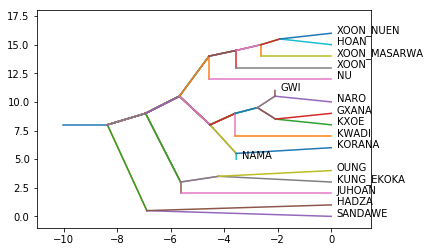

In [6]:
KhoisanPT.showtree()

By applying the class methods `RouteChooser` and `TimeInPlace`, we come up with migratory routes through all the potential locations in the tree, and are also able to see what our parameters and tree structure imply for the organization of the tree. Let's give it a go and see what happens. 

In [7]:
KhoisanPT.RouteChooser()
KhoisanPT.TimeInPlace()

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


Once these two things are done, we can plot latitudes and longitudes. The bigger circles and deeper colors are where our algorithm suggests the route of the tree is. The code opens up a new `mplleaflet` map. This is really just for fun and verification - later, when we actually start estimating trees, we will probably drag in the big guns - like **QGIS** to make a more comprehensive interactive map with data and all that. As an illustration, the following produces a plot of the data, where darker circles indicate greater time depth in the location.

In [8]:
KhoisanPT.latlonplot(os.getcwd() + '//IEMaps//PrelimKhoisanPlot.html' ,"Blues")

I don't know why it is making such a big gap - it doesn't look great, but at least it seems to be working! Next, let's move on to another Tree and see where that gets us. 

## Na Dene Language Stock

The so-called Na Dene languages in include all the Athabaskan languages of Eastern and Western Canada, Apache, Navajo, and also, to varying degrees of controversy, the Tlingit, Eyak, and Haida languages. So, let's take a crack at setting up a tree and see how it goes. This is basically just a matter of copying and pasting the above code to see where it gets us.

In [9]:
NaDeneRT = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'NADENE'], 'NTree1')  #Create a resolved tree
numbranches = NaDeneRT.interiorbranches                                                #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)           #Make a conformable set of parameters
rInit       = np.zeros((1, len(NaDeneRT.words)))                                       #initial rate parameters
dparms      = np.sum(NaDeneRT.deathmat[:,0] == 0)                                      #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                #Values for death parameters
eInit       = np.matrix(5)                                                             #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))                                  #Stack them all together

In [10]:
NaDenePT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='NADENE'],'NTree1',parmsInit)

In [11]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'NaDene'])
max = np.array(Depths['max'].loc[Depths['phylum'] == 'NaDene'])
NaDenePT.priordepth(min,max)
NaDenePT.splitinfo(Splits[Splits['phylum'] == 'NaDene'])

NaDenePT.settimes()


For reasons that I can't ascertain, the `matplotlib` settings are being reset. So, here we go: 

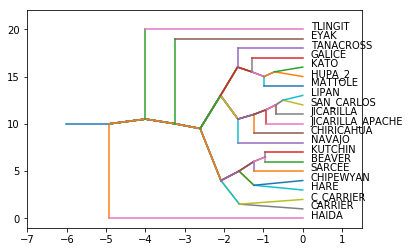

In [12]:
NaDenePT.showtree()

Given this tree, what does it say about where the Na-Dene language group likely first originated? Let's do the usual steps and make a slippy map:

In [13]:
NaDenePT.RouteChooser()
NaDenePT.TimeInPlace()
NaDenePT.latlonplot(os.getcwd() + '//IEMaps//PrelimNaDeneMap.html', "Reds")

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


So we see again that the likeliest place of origin is where the most divergent group is located. How about we try a bigger tree like AfroAsiatic? 

## Afro-Asiatic languages

This group of languages includes Hebrew, Arabic, Chadic and Omotic languages - not to mention ancient Egyptian! The languages are distributed throughout Northern Africa and the Middle East. Let's get a preliminary tree and see what it looks like:

In [14]:
AfroAsiaRT = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'AFROASIA'], 'AATree1')  #Create a resolved tree
numbranches = AfroAsiaRT.interiorbranches                                                   #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                #Make a conformable set of parameters
rInit       = np.zeros((1, len(AfroAsiaRT.words)))                                          #initial rate parameters
dparms      = np.sum(AfroAsiaRT.deathmat[:,0] == 0)                                         #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                     #Values for death parameters
eInit       = np.matrix(5)                                                                  #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))                                       #Stack them all together

In [15]:
AfroAsiaPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='AFROASIA'],'NTree1',parmsInit)

In [16]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'AfroAsia '])           # Notice the space after "AfroAsia"
max = np.array(Depths['max'].loc[Depths['phylum'] == 'AfroAsia '])           # Should be fixed!
AfroAsiaPT.priordepth(min,max)
AfroAsiaPT.splitinfo(Splits[Splits['phylum'] == 'AfroAsia '])

AfroAsiaPT.settimes()


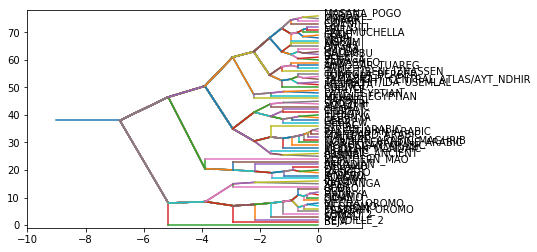

In [17]:
AfroAsiaPT.showtree()

The above is a bit hard to see, but one can zoom in and check it out in more detail. In any case, let's make a lat-lon plot of the above as well, to see what's happening. 

In [18]:
AfroAsiaPT.RouteChooser()
AfroAsiaPT.TimeInPlace()
AfroAsiaPT.latlonplot(os.getcwd() + '//IEMaps//PrelimAfroAsiaMap.html', "Purples")

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


One of the interesting things is that how the tree is resolved has a large impact on where the most likely point of origin is. If one runs the above over and over again, one gets very different answers! This is why we want to optimize the tree, and also be able to make probabilistic statements about points of origin. 

## Indo-Hittite Language Stock

A big and controversial family that includes almost all languages of Western Europe, but also languages of Iran and India. Competing theories of the point of origin are also out there - while now most seem to think the languages originated in Anatolia, in the past people have espoused the belief that they originated on the steppes of Russia to the north. Anyways...

In [19]:
IndoHittRT = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'INDOHITT'], 'IHTree1')  #Create a resolved tree
numbranches = IndoHittRT.interiorbranches                                                   #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                #Make a conformable set of parameters
rInit       = np.zeros((1, len(AfroAsiaRT.words)))                                          #initial rate parameters
dparms      = np.sum(IndoHittRT.deathmat[:,0] == 0)                                         #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                     #Values for death parameters
eInit       = np.matrix(5)                                                                  #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))                                       #Stack them all together

In [20]:
IndoHittPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='INDOHITT'],'IHTree1',parmsInit)

In [21]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'IndoHitt'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'IndoHitt'])           
IndoHittPT.priordepth(min,max)
IndoHittPT.splitinfo(Splits[Splits['phylum'] == 'IndoHitt'])

IndoHittPT.settimes()


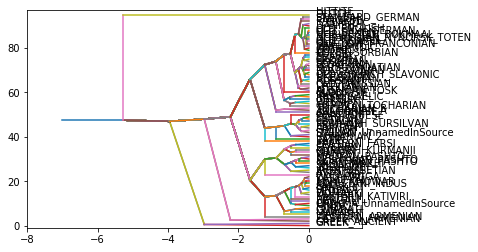

In [22]:
IndoHittPT.showtree()

In [23]:
IndoHittPT.RouteChooser()
IndoHittPT.TimeInPlace()
IndoHittPT.latlonplot(os.getcwd() + '//IEMaps//PrelimIndoHittiteMap.html', "Greys")

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


Anatolia is suggested as the most likely point of origin, at least given this tree resolution. 

## Altaic Languages

These languages include Turkic, Mongol, Khalka, Khazak, and, perhaps, very controversially, Japonese, Korean, Ainu, and other Japonic languages. I put them all together because of Ruhlen's book, but I'm not sure if this is correct. In any case:

In [24]:
AltaicRT    = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'ALTAIC'], 'AlTree1')  #Create a resolved tree
numbranches = AltaicRT.interiorbranches                                                   #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                #Make a conformable set of parameters
rInit       = np.zeros((1, len(AltaicRT.words)))                                          #initial rate parameters
dparms      = np.sum(AltaicRT.deathmat[:,0] == 0)                                         #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                     #Values for death parameters
eInit       = np.matrix(5)                                                                  #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))                                       #Stack them all together

In [25]:
AltaicPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='ALTAIC'],'AlTree1',parmsInit)

In [26]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'Altaic '])           # Notice the space after "AfroAsia"
max = np.array(Depths['max'].loc[Depths['phylum'] == 'Altaic '])           # Should be fixed!
AltaicPT.priordepth(min,max)
AltaicPT.splitinfo(Splits[Splits['phylum'] == 'Altaic '])

AltaicPT.settimes()

<IPython.core.display.Javascript object>


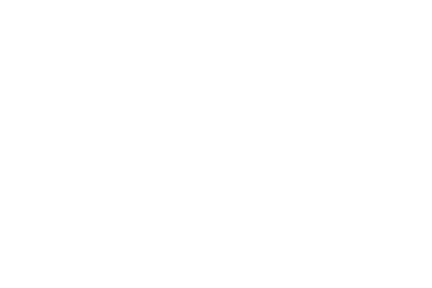

<IPython.core.display.Javascript object>


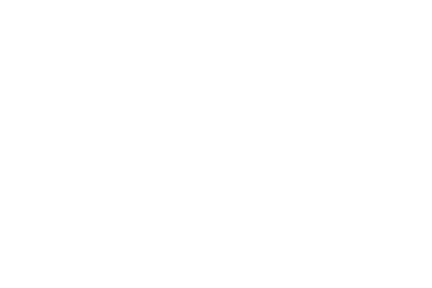

In [27]:
%matplotlib notebook
AltaicPT.showtree()

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


<IPython.core.display.Javascript object>


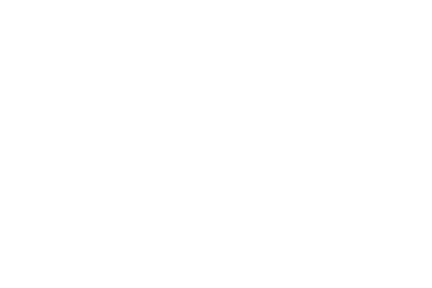

In [28]:
AltaicPT.RouteChooser()
AltaicPT.TimeInPlace()
AltaicPT.latlonplot(os.getcwd() + '//IEMaps//PrelimAltaicMap.html')

## Amerind Language Stock

This is probably Joseph Greenberg's Most controversial construction ever. Essentially, that all languages in North and South America belong to one stock, excepting the Na Dene languages and the Eskimo-Aleut Languages. We might have to redo this, but let's see what happens if we try to model them all at once, and where our approach suggests that these languages originated. 

As an aside, I also demonstrate use of the `cmap` feature for the `latlonplot()` method. 

In [29]:
AmerindRT    = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'AMERIND'], 'AmTree1')  #Create a resolved tree
numbranches = AmerindRT.interiorbranches                                                     #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                 #Make a conformable set of parameters
rInit       = np.zeros((1, len(AmerindRT.words)))                                            #initial rate parameters
dparms      = np.sum(AmerindRT.deathmat[:,0] == 0)                                           #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                      #Values for death parameters
eInit       = np.matrix(5)                                                                   #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))                                        #Stack them all together

In [30]:
AmerindPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='AMERIND'],'AmTree1',parmsInit)

In [31]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'Amerind'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'Amerind'])           
AmerindPT.priordepth(min,max)
AmerindPT.splitinfo(Splits[Splits['phylum'] == 'Amerind'])

AmerindPT.settimes()

<IPython.core.display.Javascript object>


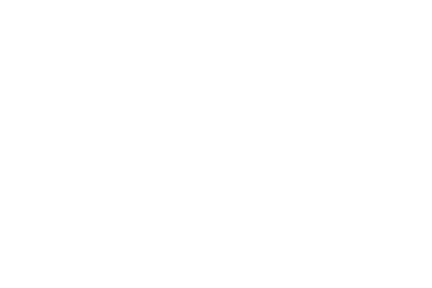

<IPython.core.display.Javascript object>


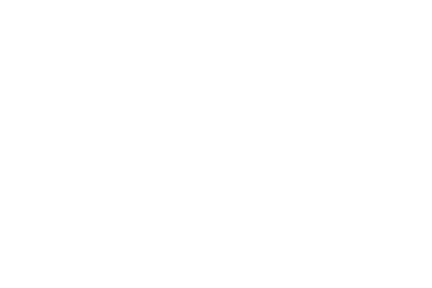

In [32]:
AmerindPT.showtree()

This is very hard to read, but let's see where it suggests this sprawling and probably wrong group started, according to our model.

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


<IPython.core.display.Javascript object>


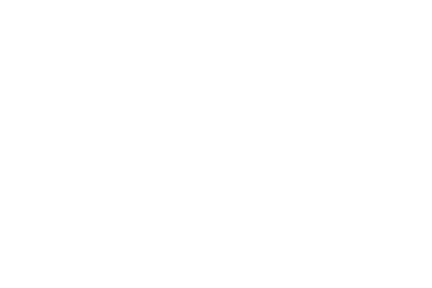

In [33]:
AmerindPT.RouteChooser()
AmerindPT.TimeInPlace()
AmerindPT.latlonplot(os.getcwd() + '//IEMaps//PrelimAmerindMap.html', 'afmhot')

## Uralic-Yukhagir Language Stock

This is an interesting linguistic group that includes Finnish, Estonian, Hungarian, and also, more controversially, the Yukhagir language spoken in East-Central Siberia. There is a bit of controversy over where it was founded, so it is interesting to see what my model suggests.

In [34]:
UralicYukRT = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'URALICYUK'], 'UYTree1')  #Create a resolved tree
numbranches = UralicYukRT.interiorbranches                                                     #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                 #Make a conformable set of parameters
rInit       = np.zeros((1, len(UralicYukRT.words)))                                            #initial rate parameters
dparms      = np.sum(UralicYukRT.deathmat[:,0] == 0)                                           #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                      #Values for death parameters
eInit       = np.matrix(5)                                                                   #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit)) 

In [35]:
UralicYukPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='URALICYUK'],'UYTree1',parmsInit)

In [36]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'UralicYuk'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'UralicYuk'])           
UralicYukPT.priordepth(min,max)
UralicYukPT.splitinfo(Splits[Splits['phylum'] == 'UralicYuk'])

UralicYukPT.settimes()

<IPython.core.display.Javascript object>


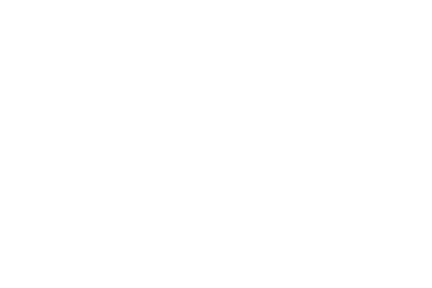

In [37]:
%matplotlib notebook
UralicYukPT.showtree()

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


<IPython.core.display.Javascript object>


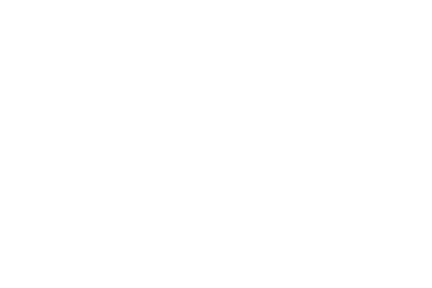

In [38]:
UralicYukPT.RouteChooser()
UralicYukPT.TimeInPlace()
UralicYukPT.latlonplot(os.getcwd() + '//IEMaps//PrelimUralicYukMap.html', 'copper')

## Eskimo-Aleut Language Stock

This grouping includes Native American languages of the extreme North ranging from Siberia to Greenland. This includes Aleut, Inupiaq, and Yupik. It is a smaller group but a very interesting one!

In [39]:
EskimoAlRT    = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'ESKIMOAL'], 'EATree1')  #Create a resolved tree
numbranches = EskimoAlRT.interiorbranches                                                     #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                 #Make a conformable set of parameters
rInit       = np.zeros((1, len(EskimoAlRT.words)))                                            #initial rate parameters
dparms      = np.sum(UralicYukRT.deathmat[:,0] == 0)                                           #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                      #Values for death parameters
eInit       = np.matrix(5)                                                                   #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit)) 

In [40]:
EskimoAlPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='ESKIMOAL'],'EATree1',parmsInit)

In [41]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'EskimoAl'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'EskimoAl'])           
EskimoAlPT.priordepth(min,max)
EskimoAlPT.splitinfo(Splits[Splits['phylum'] == 'EskimoAl'])

EskimoAlPT.settimes()

<IPython.core.display.Javascript object>


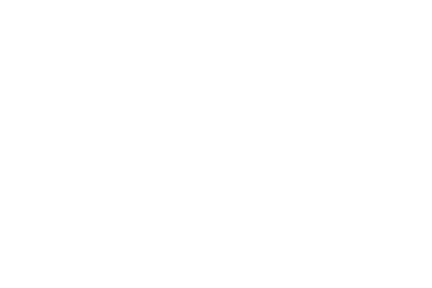

In [42]:
%matplotlib notebook
EskimoAlPT.showtree()

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


<IPython.core.display.Javascript object>


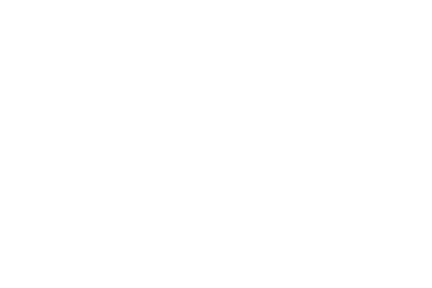

In [43]:
EskimoAlPT.RouteChooser()
EskimoAlPT.TimeInPlace()
EskimoAlPT.latlonplot(os.getcwd() + '//IEMaps//PrelimEskimoAlMap.html', 'RdPu')

## Niger-Kordofanian Stock

This is another large group which I don't think is that controversial. The Kordofanian languages are the Niger-Congo languages are the two major devisions of the group, of which the former are in Cameroon/Nigeria and all through Southern Africa - including Bantu languages - while the latter are situated in and near Sudan. 

In [44]:
NigerKordRT    = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'NIGERKORD'], 'NKTree1')  #Create a resolved tree
numbranches = NigerKordRT.interiorbranches                                                       #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                     #Make a conformable set of parameters
rInit       = np.zeros((1, len(NigerKordRT.words)))                                              #initial rate parameters
dparms      = np.sum(NigerKordRT.deathmat[:,0] == 0)                                             #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                          #Values for death parameters
eInit       = np.matrix(5)                                                                       #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit)) 

In [45]:
NigerKordPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='NIGERKORD'],'NKTree1',parmsInit)

In [46]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'NigerKord'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'NigerKord'])           
NigerKordPT.priordepth(min,max)
NigerKordPT.splitinfo(Splits[Splits['phylum'] == 'NigerKord'])

NigerKordPT.settimes()

<IPython.core.display.Javascript object>


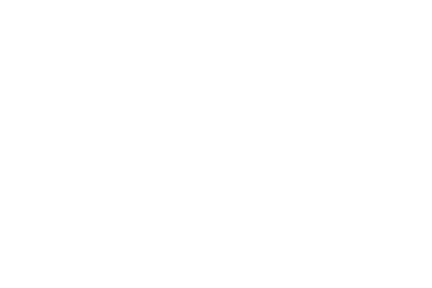

In [47]:
%matplotlib notebook
NigerKordPT.showtree()

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


<IPython.core.display.Javascript object>


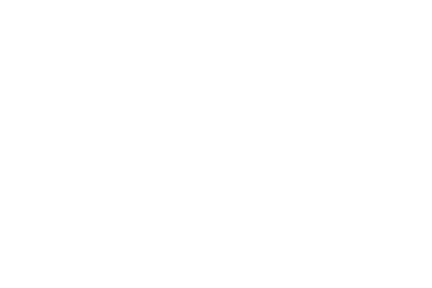

In [48]:
NigerKordPT.RouteChooser()
NigerKordPT.TimeInPlace()
NigerKordPT.latlonplot(os.getcwd() + '//IEMaps//NigerKordMap.html', 'cool')

## Nilo-Saharan Language Stock

The last of the four great linguistic classifications of Africa, spread throughout Sub-Sub-Saharan Africa. 

In [49]:
NiloSaharRT    = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'NILOSAHAR'], 'NSTree1')  #Create a resolved tree
numbranches = NiloSaharRT.interiorbranches                                                       #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                     #Make a conformable set of parameters
rInit       = np.zeros((1, len(NiloSaharRT.words)))                                              #initial rate parameters
dparms      = np.sum(NiloSaharRT.deathmat[:,0] == 0)                                             #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                          #Values for death parameters
eInit       = np.matrix(5)                                                                       #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit)) 

In [50]:
NiloSaharPT=PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='NILOSAHAR'],'NSTree1',parmsInit)

In [51]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'NiloSahar'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'NiloSahar'])           
NiloSaharPT.priordepth(min,max)
NiloSaharPT.splitinfo(Splits[Splits['phylum'] == 'NiloSahar'])

NiloSaharPT.settimes()

<IPython.core.display.Javascript object>


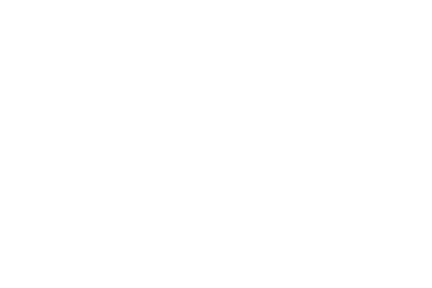

In [52]:
%matplotlib notebook
NiloSaharPT.showtree()

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


<IPython.core.display.Javascript object>


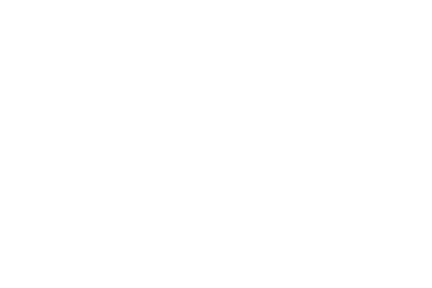

In [53]:
NiloSaharPT.RouteChooser()
NiloSaharPT.TimeInPlace()
NiloSaharPT.latlonplot(os.getcwd() + '//IEMaps//PrelimNiloSaharMap.html', 'Reds')

## Austric Language Stock

Perhaps the most geographically dispersed group - languages from Hawaii to Easter Island to Madagascar. The expansion is typically believed to have gained traction in Taiwan - at which point the Austronesian expansion began to cover most of the South Pacific.


In [54]:
AustricRT    = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'AUSTRIC'], 'AuTree1')  #Create a resolved tree
numbranches = AustricRT.interiorbranches                                                       #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                     #Make a conformable set of parameters
rInit       = np.zeros((1, len(AustricRT.words)))                                              #initial rate parameters
dparms      = np.sum(AustricRT.deathmat[:,0] == 0)                                             #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                          #Values for death parameters
eInit       = np.matrix(5)                                                                       #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))

In [55]:
AustricPT = PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='AUSTRIC'],'AuTree1',parmsInit)

In [56]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'Austric'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'Austric'])           
AustricPT.priordepth(min,max)
AustricPT.splitinfo(Splits[Splits['phylum'] == 'Austric'])

AustricPT.settimes()

<IPython.core.display.Javascript object>


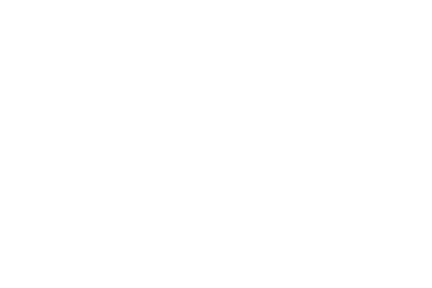

In [57]:
%matplotlib notebook
AustricPT.showtree()

Locations: one would hope that it predicts what is roughly known to be the truth!

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


<IPython.core.display.Javascript object>


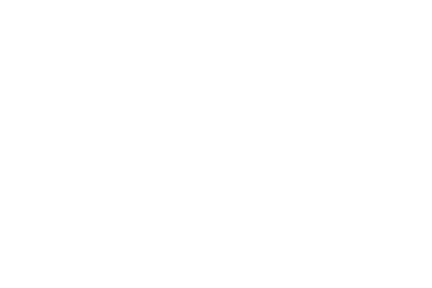

In [58]:
AustricPT.RouteChooser()
AustricPT.TimeInPlace()
AustricPT.latlonplot(os.getcwd() + '//IEMaps//PrelimAustricMap.html', 'Greens')

Austric is apparently one situation where the initial guess doesn't seem to be all that close to the reality of the migration pattern, beyond putting the route somewhere in South East Asia with a (very) early movement to Taiwan. 

## Indo-Pacific Language Stock

This is very controversial. Andamanese in there with languages of New Guinea? And Tasmanian? Also, these languages are apparently very hard to group.  Anyways, what do we get if we put them all together, even for a randomly drawn tree? 

In [59]:
IndoPacRT    = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'INDOPAC'], 'IPTree1')  #Create a resolved tree
numbranches = IndoPacRT.interiorbranches                                                     #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                 #Make a conformable set of parameters
rInit       = np.zeros((1, len(IndoPacRT.words)))                                            #initial rate parameters
dparms      = np.sum(IndoPacRT.deathmat[:,0] == 0)                                           #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                      #Values for death parameters
eInit       = np.matrix(5)                                                                   #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))

In [60]:
IndoPacPT = PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='INDOPAC'],'IPTree1',parmsInit)

In [61]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'IndoPac'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'IndoPac'])           
IndoPacPT.priordepth(min,max)
IndoPacPT.splitinfo(Splits[Splits['phylum'] == 'IndoPac'])

IndoPacPT.settimes()

<IPython.core.display.Javascript object>


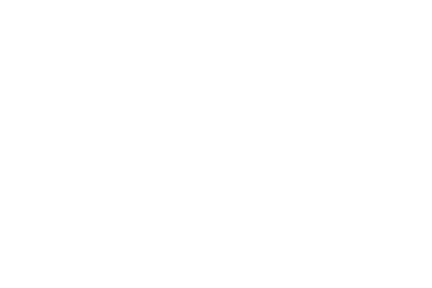

In [62]:
%matplotlib notebook
IndoPacPT.showtree()

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1484: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T


<IPython.core.display.Javascript object>


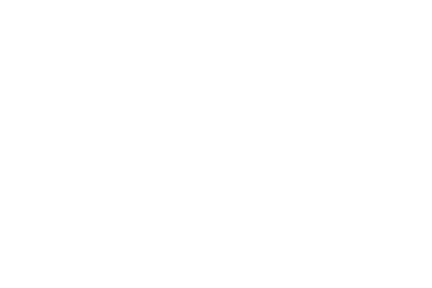

In [63]:
IndoPacPT.RouteChooser()
IndoPacPT.TimeInPlace()
IndoPacPT.latlonplot(os.getcwd() + '//IEMaps//PrelimIndoPacMap.html', 'Greys')

## Sino-Tibetan

In [64]:
SinoTibetRT    = PyInstEvo.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'SINOTIBET'], 'STTree1')  #Create a resolved tree
numbranches = SinoTibetRT.interiorbranches                                                       #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)                     #Make a conformable set of parameters
rInit       = np.zeros((1, len(SinoTibetRT.words)))                                              #initial rate parameters
dparms      = np.sum(SinoTibetRT.deathmat[:,0] == 0)                                             #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                          #Values for death parameters
eInit       = np.matrix(5)                                                                       #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))

In [65]:
SinoTibetPT = PyInstEvo.ParameterizedTree(Data.loc[Data['ruhlen_1']=='SINOTIBET'],'STTree1',parmsInit)

In [66]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'SinoTibet'])           
max = np.array(Depths['max'].loc[Depths['phylum'] == 'SinoTibet'])           
SinoTibetPT.priordepth(min,max)
SinoTibetPT.splitinfo(Splits[Splits['phylum'] == 'SinoTibet'])

SinoTibetPT.settimes()

<IPython.core.display.Javascript object>


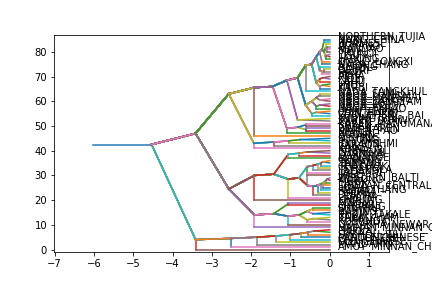

In [67]:
%matplotlib notebook
SinoTibetPT.showtree()

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:742: RuntimeWarning: divide by zero encountered in log
  LL[tu[p]] = LL[tu[p]] + IndCount[tu[p]]*(np.log(IndCount[tu[p]]) - np.log(TM[tu[p]])) + LLHat[p]
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:1600: RuntimeWarning: divide by zero encountered in log
  toGet = np.matrix(-np.log(D))[origin,:][:,colns].T
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  Probs = np.exp(lnProbs2u)/np.sum(np.exp(lnProbs2u))
C:\Users\mjbaker\Documents\GitHub\InstEvo\PyInstEvo.py:668: RuntimeWarning: invalid value encountered in less
  return np.max(np.where(rs < pick)[0])


<IPython.core.display.Javascript object>


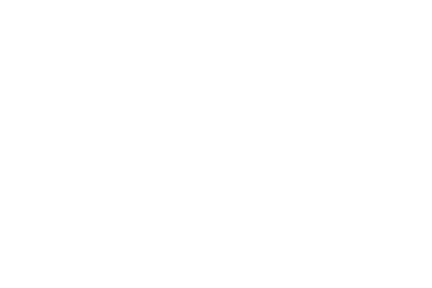

In [68]:
SinoTibetPT.RouteChooser()
SinoTibetPT.TimeInPlace()
SinoTibetPT.latlonplot(os.getcwd() + '//IEMaps//PrelimSinoTibetMap.html', 'YlGn')

## Lessons

At this point, it looks as though our random drawings and model are at least producing results and not blowing up. And while the basic facts seem to accord with reality, there are some big mistakes in there! I suspect that linguistic information and maximum likelihood puzzling of trees should clean this up to some degree. 

We also haven't plotted all the families out. We haven't plotted Australian languages, Elamo-Dravidian languages, Caucasian languages, or any of the isolates (Sumerian, Basque, Khet, Burusho, for example). We can save this for after estimation. 